# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

The `CLOUD` parameter is a for installing the requirements within a controlled
environment such as the Udacity environment such that you can run the program.
If you have the requirements installed per the README - set `CLOUD = False`

In [1]:
CLOUD = True
if CLOUD: 
    !pip -q install ./python
    !pip -q install toml
    !pip -q install requests
    !pip freeze > requirements.txt
    !mkdir -p runs/

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## Tennis - Solution

Once you have your environment established - you can now train the Multi-agent
but first, let's describe the approach.

### Project Architecture

Much of the solution is leveraged from the [Continuous Control Project](https://github.com/amcumber/udacity-rl-continuous-control).
As such, much of the the same structure where three primary classes are
used the `EnvironmentMgr`, `Trainer`, and the `Agent`

1. `EnvironmentMgr` - Each `EnvironmentMgr` class contains common commands the
   `Trainer` can interface with to command the environment to `start`, `step`,
   `reset`, `get_evn`, and `close`.
   
2. `Trainer` - This class is intended to hold all of the properties for the
   experiment and manipulate both the `Agent` and the `Environment`.
   
3. `Agent` - This is the class that holds the reinforcement learning agent and
   maintains a similar structure to other implementations with minor edits for
   function encapsulation.

#### Agent Selection

Similarly, Deep Deterministic Policy Gradient (DDPG) agents were selected
for this solution, however, due to the nature of the problem, multi-agent
was selected. To do so, the `ReplayBuffer` was shared between the two
agents in order to play the game.

In order to allow state exploration, two approaches were attempted.
First a version of [Parameter Noise](https://openai.com/blog/better-exploration-with-parameter-noise/)
was first implemented with the mult-agent DDPG, but ultimately was scratched
due to a few bugs in the code and little reference architectures to compare
against. Instead, another version of the Ornstein-Uhlenbeck (OU) process 
was implemented to the action noise of the model. Additionally, noise-decay
was not implemented in the final solution due to increased performance observed
with OU noise at longer time steps (for this specific application).

#### DDPG

DDPG originally proposed in the 
[2016 Google Deepmind Paper](https://arxiv.org/pdf/1509.02971.pdf)
proposes a DPG method applying Q-learning. The architecture consists of two 
deep networks, an Actor and a Critic. The Actor determines the action provided
the environment state. The Critic rates the Actor's action as good or bad 
provided the state and the actor's action. Both the actor and critic maintain
two networks each as a local and a target network. Where the best action is
selected from the target action and the local network learns from the response.
Over the course of training the target network will be updated using a 
`soft_update` algorithm where a parameter $\tau$ dictates the percent weight of
the local network to update to the target network.

#### Neural Network Model Architecture

After reviewing several times with fellow students and discussing with mentors
within the forums. I've selected an `Actor` Model consisting of `3` fully 
connected layers with hidden layers of `256` and `128` units wide and input
units equal to the state size and output units equal to the action size. For
the `Critic` Model, I've constructed a `3` fully connected model again with
hidden layers equal to `256` and `128` units wide, but following the 
recommendation of Agents of this structure to inject the states as inputs into
the first layer and actions into the second. Finally, outputting a single node.

Similar to the [Original DDPG paper](https://arxiv.org/pdf/1509.02971.pdf), 
similar deep architectures were constructed for the Actor and Critic. For 
activation functions, the `ReLU` function was used for the `Actor` to 
minimize complexity and the hyperbolic tangent function (`tanh`) was used as
output for the `Actor`. The tanh function provides a continuous space 
between action bounds for the actor to select from. The `Critic` maintains a
similar architecture to the architecture provided in the paper where the 
environment state is passed into a fully connected (FC) layer and the following
hidden layer ingests the output of that FC layer plus the action of the Actor.
The output of the Critic is simply a single node used to determine if the 
action was good or bad.

Weights were initialized using uniform distribution from 
$\mp\frac{1}{\sqrt{N_{input}}}$ for all of the nodes save for the final node
where a uniform distribution between $\mp3e-3$ was established.

With the primary architecture described, now let's load the packages and 
hyperparameters to discuss further

## Load Packages

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from tennis_agents.factory import TennisFactory
from tennis_agents.workspace_utils import active_session
from tennis_agents.plotting import plot_scores

In [6]:
# Inst classes
factory = TennisFactory()
data = factory.read_toml('config.toml')
envh = factory.get_environment_manager(data)

#### Intermediate Run Break

Run from here if rerunning the same environment.

In [7]:
# Separate run instance if reload config
data = factory.read_toml('config.toml')
maddpg = factory.get_agent(data)
trainer = factory.get_trainer(data, envh, maddpg)


## Actor / Critic Structure

Both the Actor and Critic were selected to have 3 fully connected layers.
Though the model displays 3 Batch Normalization layers, only `bn2` was used
in the solution. The additional layers were kept to allow easy experimentation
between structures.

```python
class Actor:
    #...
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = state
        # x = self.bn1(x)
        x = self.fc1(x)
        x = self.act_func(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.act_func(x)
        # x = self.bn3(x)
        x = self.fc3(x)
        x = torch.tanh(x) * self.upper_bound
        return x

```

The Critic has an additional dropout layer that was implemented between fc2 and
fc3. This addition was suggested by a couple of students for improved performance.

```python
class Critic:
    # ...
    def forward(self, state, action):
        """
        Build a critic (value) network that maps (state, action)
        pairs -> Q-values.
        """
        x = state
        # x = self.bn1(x)
        x = self.fc1(x)
        x = self.act_func(x)
        x = torch.cat((x, action), dim=1)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.act_func(x)
        # x = self.bn3(x)
        x = self.drop(x)
        x = self.fc3(x)
        return x
```

In [8]:
maddpg.agents[0].actor_local

DDPGActor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Hyper Parameter selection

* Learning Rate - Several learning rates were tested and provided this specific
  architecture, a learning rate of 1e-3 for both Actor and Critic provided the 
  best performance without introducing unacceptable instability.
* Weight Decay - Was found to have improved performance when introduced (as
  opposed to when absent).
* Gamma - A large gamma of 0.99 was selected again due to the desire to
  encourage future rewards.
* Learning Frequency - Despite several suggestions by other students, my model
  observed improved performance with the highest learning frequency where the 
  target network is updated at every episode.
* Number of Episodes - Unfortunately, the model architecture is not as 
  efficient as some other student models (some of which have solved the environment
  in <2000 episodes), so a larger value was set to ensure the model does reach
  the required average score.

In [9]:
display(data)

{'environment': {'ENV_FILE': '/data/Tennis_Linux_NoVis/Tennis',
  'STATE_SIZE': 24,
  'ACTION_SIZE': 2,
  'UPPER_BOUND': 1.0,
  'SOLVED': 0.5,
  'ROOT_NAME': 'tennis',
  'SEED': 42},
 'trainer': {'N_EPISODES': 3000, 'MAX_T': 2000, 'WINDOW_LEN': 100},
 'memory': {'BATCH_SIZE': 128, 'BUFFER_SIZE': 100000.0},
 'agent': {'N_AGENTS': 2,
  'LEARN_F': 1,
  'GAMMA': 0.99,
  'TAU': 0.001,
  'LR_ACTOR': 0.001,
  'LR_CRITIC': 0.001,
  'WEIGHT_DECAY': 1e-06,
  'ACTOR_HIDDEN': [128, 64],
  'CRITIC_HIDDEN': [128, 64],
  'ACTOR_ACT': 'relu',
  'CRITIC_ACT': 'relu',
  'ADD_NOISE': [True, True],
  'NOISE_DECAY': 1.0},
 'noise': {},
 'OU': {'SIGMA': 0.01, 'MU': 0.0, 'THETA': 0.15},
 'AP': {'INITIAL_STD': 0.1, 'DESIRED_ACTION_STD': 0.2, 'ADOPTION_COEF': 1.01}}

In [10]:
trainer.magent.agents[0].device


device(type='cuda', index=0)

In [11]:
display(trainer.magent.agents[0].actor_local)
display(trainer.magent.agents[0].critic_local)

DDPGActor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

DDPGCritic(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=130, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2)
)

In [12]:
if CLOUD:
    with active_session():
        scores = trainer.train()
else:
    scores = trainer.train()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Ep 100	Best (all): 0.1000	Mean (window): 0.0020
Ep 200	Best (all): 0.1000	Mean (window): 0.0084
Ep 300	Best (all): 0.1000	Mean (window): 0.0000
Ep 400	Best (all): 0.1000	Mean (window): 0.0000
Ep 500	Best (all): 0.1000	Mean (window): 0.0000
Ep 600	Best (all): 0.1000	Mean (window): 0.0020
Ep 700	Best (all): 0.1000	Mean (window): 0.0131
Ep 800	Best (all): 0.2000	Mean (window): 0.0421
Ep 900	Best (all): 0.3000	Mean (window): 0.0289
Ep 1000	Best (all): 0.3000	Mean (window): 0.0257
Ep 1100	Best (all): 0.3000	Mean (window): 0.0386
Ep 1200	Best (all): 0.3000	Mean (window): 0.0667
Ep 1300	Best (all): 0.4000	Mean (window): 0.0939
Ep 1400	Best (all): 0.5000	Mean (window): 0.0957
Ep 1500	Best (all): 0.5000	Mean (window): 0.1307
Ep 1600	Best (all): 0.5000	Mean (window): 0.0826
Ep 1700	Best (all): 0.5000	Mean (window): 0.0600
Ep 1800	Best (all): 0.5000	Mean (window): 0.0644
Ep 1900	Best (all): 0.5000	Mean (window): 0.0659
Ep 2000	Best (all): 0.6000	Mean (window): 0.0689
Ep 2100	Best (all): 0.6000	Me

## Visualize
Visualize the scores of the trained agent. 

* The `i_map` parameter to rotate through the seaborn color palette (paired in 
  groups of 2)
  * 0: blue
  * 1: green
  * 2: red
  * 3: orange
  * 4: purple

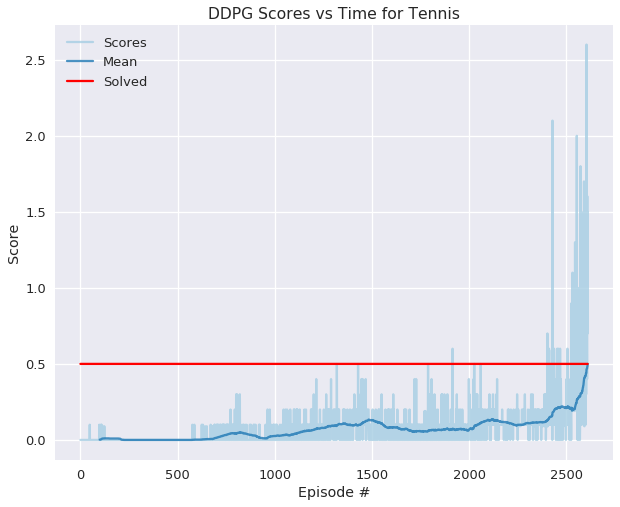

In [13]:
fig = plot_scores(scores)

In [14]:
fig.savefig('runs/last_run.png');

In [15]:
trainer.save_scores('runs/scores-checkpoint.pkl')

## Results

The model is able to achieve the required average score of `>0.5` in `2610` 
episodes.

## Future Working

After implementing DDPG for two projects now, the identified shortcomings of
DDPG have become apparent, particularly with the replay buffer. Oscillatory
behavior within the Tennis model is common and I hypothesize is due to the 
model forgetting the valuable experiences when they run to the end of the 
buffer and having to relearn them. Implementing Proximal Policy Optimization
or Asynchronous Actor Critic methods may demonstrate suppressed unstable 
behavior and certainly worth exploring - especially for similar online
implementations that require agent stability.